### Applying Deep Learning to S&P 500 
  - [Data wrangling](#dw)
  - [Quick analysis with Linear Regression](#LR)
  - [Stationary tests](#stationary)
  - [Applying LSTM on stationary data](#LSTM_sta)
  - [Applying LSTM on non-stationary data](#LSTM_non-sta)

---
<a name='dw' ></a>
### Data wrangling

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Using TensorFlow backend.


In [2]:
# Data Munging
sp500 = pd.read_csv('S&P.csv')
sp500.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2017-03-24,2350.419922,2356.219971,2335.739990,2343.979980,2975130000,2343.979980
1,2017-03-23,2345.969971,2358.919922,2342.129883,2345.959961,3260600000,2345.959961
2,2017-03-22,2343.000000,2351.810059,2336.449951,2348.449951,3572730000,2348.449951
3,2017-03-21,2379.320068,2381.929932,2341.899902,2344.020020,4265590000,2344.020020
4,2017-03-20,2378.239990,2379.550049,2369.659912,2373.469971,3054930000,2373.469971


In [3]:
sp500.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
15115,1957-03-08,44.070000,44.070000,44.070000,44.070000,1630000,44.070000
15116,1957-03-07,44.209999,44.209999,44.209999,44.209999,1830000,44.209999
15117,1957-03-06,44.230000,44.230000,44.230000,44.230000,1840000,44.230000
15118,1957-03-05,44.220001,44.220001,44.220001,44.220001,1860000,44.220001
15119,1957-03-04,44.060001,44.060001,44.060001,44.060001,1890000,44.060001


In [4]:
sp500.shape

(15120, 7)

In [5]:
sp500.columns = sp500.columns.str.strip().str.lower()

In [6]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 7 columns):
date         15120 non-null object
open         15120 non-null float64
high         15120 non-null float64
low          15120 non-null float64
close        15120 non-null float64
volume       15120 non-null int64
adj close    15120 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 827.0+ KB


In [7]:
sp500.date.unique().shape

(15120,)

In [8]:
sp500['date']=sp500['date'].apply(lambda x: dt.strptime(x,'%Y-%m-%d'))
# Note: y for 2digit yeardate, Y for 4digit yeardate.

In [9]:
sp500.set_index('date',inplace=True)

In [10]:
sp500.sort_index(ascending=True,inplace=True)

In [11]:
sp500.head()

,open,high,low,close,volume,adj close
date,,,,,,
1957-03-04,44.060001,44.060001,44.060001,44.060001,1890000,44.060001
1957-03-05,44.220001,44.220001,44.220001,44.220001,1860000,44.220001
1957-03-06,44.230000,44.230000,44.230000,44.230000,1840000,44.230000
1957-03-07,44.209999,44.209999,44.209999,44.209999,1830000,44.209999
1957-03-08,44.070000,44.070000,44.070000,44.070000,1630000,44.070000


In [12]:
sp500.tail()

,open,high,low,close,volume,adj close
date,,,,,,
2017-03-20,2378.239990,2379.550049,2369.659912,2373.469971,3054930000,2373.469971
2017-03-21,2379.320068,2381.929932,2341.899902,2344.020020,4265590000,2344.020020
2017-03-22,2343.000000,2351.810059,2336.449951,2348.449951,3572730000,2348.449951
2017-03-23,2345.969971,2358.919922,2342.129883,2345.959961,3260600000,2345.959961
2017-03-24,2350.419922,2356.219971,2335.739990,2343.979980,2975130000,2343.979980


In [13]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15120 entries, 1957-03-04 to 2017-03-24
Data columns (total 6 columns):
open         15120 non-null float64
high         15120 non-null float64
low          15120 non-null float64
close        15120 non-null float64
volume       15120 non-null int64
adj close    15120 non-null float64
dtypes: float64(5), int64(1)
memory usage: 826.9 KB


In [14]:
sp500.rename(columns={'adj close': 'adj_close'},inplace=True)

In [15]:
sp500.drop(['open','high','low','close','volume'],axis=1,inplace=True)

In [16]:
sp500.head()

,adj_close
date,
1957-03-04,44.060001
1957-03-05,44.220001
1957-03-06,44.230000
1957-03-07,44.209999
1957-03-08,44.070000


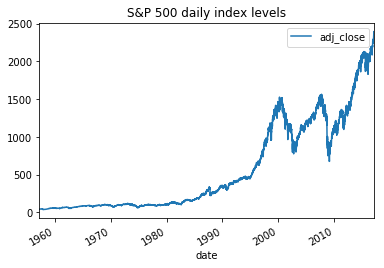

In [17]:
sp500.plot()
plt.title('S&P 500 daily index levels')
plt.show()

In [18]:
sp500.describe()

,adj_close
count,15120.000000
mean,572.036051
std,603.857573
min,38.980000
25%,95.367503
50%,252.200004
75%,1106.377502
max,2395.959961


---
<a name='LR'></a>
### Linear Regression

In [19]:
# Linear Regression (train:test=7:3, ignore stationarity)
train_size=int(len(sp500)*0.7)
test_size=len(sp500)-train_size

In [20]:
train,test=sp500[0:train_size],sp500[train_size:]

In [21]:
X_data = sp500[:-1]
y_data = sp500[1:]

In [22]:
X_train = pd.DataFrame(X_data[0:train_size])
X_test = pd.DataFrame(X_data[train_size:])
y_train = y_data[0:train_size].values
y_test = y_data[train_size:].values

In [23]:
lr = LinearRegression()
lr_mod = lr.fit(X_train,y_train)
print('Score: %.2f' % lr.score(X_test,y_test))

Score: 1.00


In [24]:
trainPredict = lr.predict(X_train)
testPredict = lr.predict(X_test)

In [25]:
# y_test.reset_index(drop=True,inplace=True)
actual_vs_pred = pd.concat([pd.DataFrame(y_test),pd.DataFrame(testPredict)],axis=1)
actual_vs_pred.columns=['actual','predict']

Text(0.5, 1.0, 'Daily Predictions')

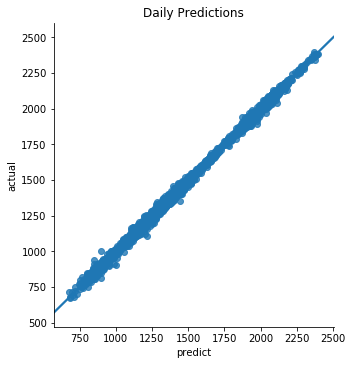

In [26]:
sns.lmplot(data=actual_vs_pred,x='predict',y='actual')
ax = plt.gca()
ax.set_title('Daily Predictions')

In [27]:
# Calculate root mean squared error (linear regression)
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for Linear Regression: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for Linear Regression: %.2f RMSE' % (testScore))

Train Score for Linear Regression: 3.37 RMSE
Test Score for Linear Regression: 15.12 RMSE


In [28]:
# Test Score for Linear Regression will be used as baseline.

Score: 0.99
Train Score for Linear Regression: 7.29 RMSE
Test Score for Linear Regression: 31.48 RMSE


Text(0.5, 1.0, 'Weekly Predictions')

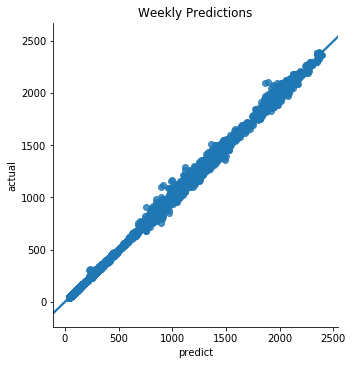

In [29]:
# LR (predict weekly)
actual_wk = sp500['adj_close'][:-5]
predict_wk = sp500['adj_close'][5:].values

train_size=int(len(actual_wk)*0.7)
test_size=len(actual_wk)-train_size

X_train=pd.DataFrame(actual_wk[:-test_size])
X_test=pd.DataFrame(actual_wk[train_size:])

y_train=predict_wk[:-test_size]
y_test=predict_wk[train_size:]

lr = LinearRegression()
lr_mod = lr.fit(X_train,y_train)
print('Score: %.2f' % lr.score(X_test,y_test))

trainPredict = lr.predict(X_train)
testPredict = lr.predict(X_test)

trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for Linear Regression: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for Linear Regression: %.2f RMSE' % (testScore))

actual_wk.reset_index(drop=True,inplace=True)
actual_vs_pred=pd.concat([pd.Series(actual_wk),pd.Series(predict_wk)],axis=1)
actual_vs_pred.columns=['actual','predict']

sns.lmplot(data=actual_vs_pred,x='predict',y='actual')
ax = plt.gca()
ax.set_title('Weekly Predictions')

# RMSE slightly worse off compared to daily predictions.

Score: 0.97
Train Score for Linear Regression: 13.39 RMSE
Test Score for Linear Regression: 60.18 RMSE


Text(0.5, 1.0, 'Monthly Predictions')

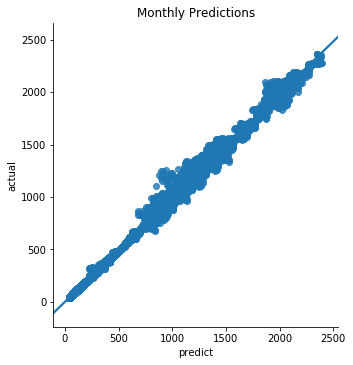

In [30]:
# Linear Regression (predict monthly)
actual_mth = sp500['adj_close'][:-20]
predict_mth = sp500['adj_close'][20:].values

train_size=int(len(actual_mth)*0.7)
test_size=len(actual_mth)-train_size

X_train=pd.DataFrame(actual_mth[:-test_size])
X_test=pd.DataFrame(actual_mth[train_size:])

y_train=predict_mth[:-test_size]
y_test=predict_mth[train_size:]

lr = LinearRegression()
lr_mod = lr.fit(X_train,y_train)
print('Score: %.2f' % lr.score(X_test,y_test))

trainPredict = lr.predict(X_train)
testPredict = lr.predict(X_test)

trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for Linear Regression: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for Linear Regression: %.2f RMSE' % (testScore))

actual_mth.reset_index(drop=True,inplace=True)
actual_vs_pred=pd.concat([pd.Series(actual_mth),pd.Series(predict_mth)],axis=1)
actual_vs_pred.columns=['actual','predict']

sns.lmplot(data=actual_vs_pred,x='predict',y='actual')
ax = plt.gca()
ax.set_title('Monthly Predictions')

# RMSE got worse.

Score: 0.23
Train Score for Linear Regression: 35.53 RMSE
Test Score for Linear Regression: 323.58 RMSE


Text(0.5, 1.0, 'Yearly Predictions')

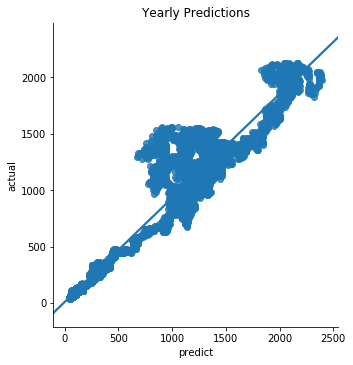

In [31]:
# Linear Regression (predict yearly)
actual_yr = sp500['adj_close'][:-252]
predict_yr = sp500['adj_close'][252:].values

train_size=int(len(actual_yr)*0.7)
test_size=len(actual_yr)-train_size

X_train=pd.DataFrame(actual_yr[:-test_size])
X_test=pd.DataFrame(actual_yr[train_size:])

y_train=predict_yr[:-test_size]
y_test=predict_yr[train_size:]

lr = LinearRegression()
lr_mod = lr.fit(X_train,y_train)
print('Score: %.2f' % lr.score(X_test,y_test))

trainPredict = lr.predict(X_train)
testPredict = lr.predict(X_test)

trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for Linear Regression: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for Linear Regression: %.2f RMSE' % (testScore))

actual_yr.reset_index(drop=True,inplace=True)
actual_vs_pred=pd.concat([pd.Series(actual_yr),pd.Series(predict_yr)],axis=1)
actual_vs_pred.columns=['actual','predict']

sns.lmplot(data=actual_vs_pred,x='predict',y='actual')
ax = plt.gca()
ax.set_title('Yearly Predictions')

# Yearly Predictions are terrible.

---
<a name='stationary'></a>
### Stationarity tests

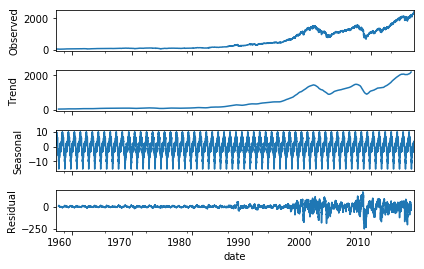

In [32]:
res=seasonal_decompose(sp500['adj_close'],freq=252,model='addictive') # Assume 252 trading days a year
res.plot()
plt.xticks(rotation=0)

plt.show()
# plt.savefig('chart1.pdf',format='pdf')

Clear seasonal trends. Noticeable residuals appeared from 1995 onwards.

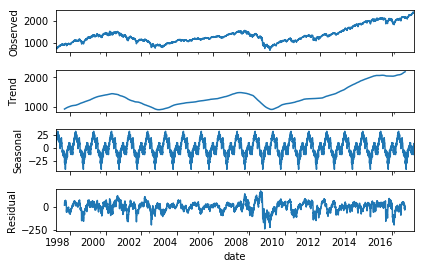

In [33]:
# Look at last 20 years (approx. 1998 to 2017)
res=seasonal_decompose(sp500['adj_close'].tail(252*20),freq=252,model='addictive')
res.plot()
plt.xticks(rotation=0)
plt.show()

Clear seasonal trends (yearly) oberserved once more.

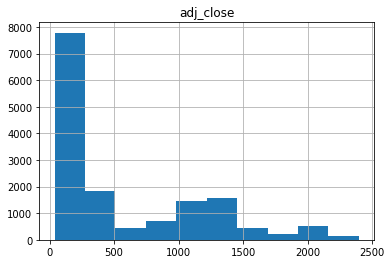

In [34]:
# Histogram
sp500.hist()
plt.show()

Distribution is not normal.

In [35]:
# Split into 2 groups and check their means and variance
split = int(len(sp500)/2)
grp1,grp2=sp500.iloc[0:split,0],sp500.iloc[split:,0]
mean1, mean2 = grp1.mean(), grp2.mean()
var1, var2 = grp1.var(), grp2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))
# Note: Very different mean & variance.

mean1=102.511926, mean2=1041.560176
variance1=1937.287000, variance2=286434.752684


In [36]:
# Augmented Dickey-Fuller (ADF) test
result = adfuller(sp500.iloc[:,0].values)
print('ADF statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key,value))
# Conclusion: Non-stationary as p-value > 0.05    

ADF statistic: 2.078626
p-value: 0.998767
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


---
### Autocorrelation and Partial Autocorrelation plots

In [37]:
day,wk,mth,yr,three_yr,five_yr,ten_yr=1,5,20,252,252*3,252*5,252*10
lags=[day,wk,mth,yr,three_yr,five_yr,ten_yr]
# lag_names=['day','week','month','year','three-year','five-year','ten-year']

In [38]:
print('1 Day Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=day))
print('1 Week Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=wk))
print('1 Month Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=mth))
print('1 Year Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=yr))
print('3 Year Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=three_yr))
print('5 Year Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=five_yr))
print('10 Year Lag Autocorrelation: %.4f' % sp500['adj_close'].autocorr(lag=ten_yr))

1 Day Lag Autocorrelation: 0.9999
1 Week Lag Autocorrelation: 0.9995
1 Month Lag Autocorrelation: 0.9985
1 Year Lag Autocorrelation: 0.9776
3 Year Lag Autocorrelation: 0.9181
5 Year Lag Autocorrelation: 0.8755
10 Year Lag Autocorrelation: 0.8428


High autocorrelations.

---
<a name='LSTM_sta'></a>
### Applying LSTM on stationary data

In [39]:
data=sp500
data['diff']=sp500['adj_close'].diff(1)

In [40]:
data.head()

,adj_close,diff
date,,
1957-03-04,44.060001,NaN
1957-03-05,44.220001,0.160000
1957-03-06,44.230000,0.009999
1957-03-07,44.209999,-0.020001
1957-03-08,44.070000,-0.139999


In [41]:
data.dropna(inplace=True)

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [43]:
rate = data[['diff']]
mms = MinMaxScaler(feature_range=(-1,1))

In [44]:
rate.head()

,diff
date,
1957-03-05,0.160000
1957-03-06,0.009999
1957-03-07,-0.020001
1957-03-08,-0.139999
1957-03-11,-0.290001


In [45]:
# With full dataset, split train/test into 70:30
train_size = int(len(rate)*0.7)
test_size = len(rate) - train_size
train,test=rate[0:train_size],rate[train_size:]
print(len(rate),train_size,test_size)

15119 10583 4536


In [46]:
mms = mms.fit(train)
train = mms.transform(train)
test = mms.transform(test)
print(train.shape,test.shape)

(10583, 1) (4536, 1)


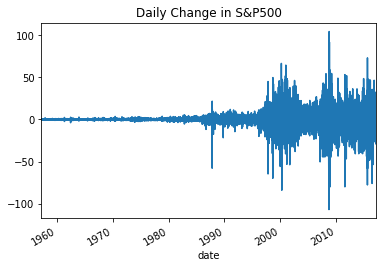

In [47]:
data['diff'].plot()
plt.title('Daily Change in S&P500')
plt.show()

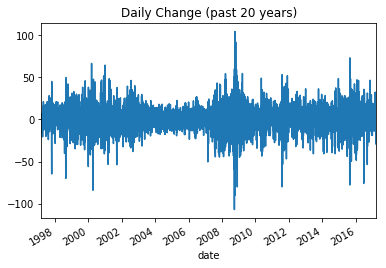

In [48]:
data['diff'].tail(252*20).plot()
plt.title('Daily Change (past 20 years)')
plt.show()

In [49]:
lag=1
X_train=np.array(train[:-lag])
y_train=np.array(train[lag:])
X_test=np.array(test[:-lag])
y_test=np.array(test[lag:])

In [50]:
time_steps = 1
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, X_test.shape[1]))

In [51]:
# Create and fit LSTM network
lag=1
np.random.seed(7)
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag))) # 4 neurons
model.add(Dense(1)) # 1 layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0033
Epoch 2/20
10582/10582 [==============================] - 63s 6ms/step - loss: 0.0032
Epoch 3/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0032
Epoch 4/20
10582/10582 [==============================] - 65s 6ms/step - loss: 0.0032
Epoch 5/20
10582/10582 [==============================] - 63s 6ms/step - loss: 0.0032
Epoch 6/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0032
Epoch 7/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0032
Epoch 8/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0032
Epoch 9/20
10582/10582 [==============================] - 64s 6ms/step - loss: 0.0032
Epoch 10/20
10582/10582 [==============================] - 63s 6ms/step - loss: 0.0032
Epoch 11/20
10582/10582 [==============================] - 62s 6ms/step - loss: 0.0032
Epoch 12/20
10582/10582 [===========================

In [52]:
# Predict with model
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
print(len(X_train),len(X_test))
print(len(trainPredict),len(testPredict))

10582 4535
10582 4535


In [53]:
# Inverse the transformations
y_train = mms.inverse_transform(y_train)
y_test = mms.inverse_transform(y_test)
testPredict = mms.inverse_transform(testPredict)
trainPredict = mms.inverse_transform(trainPredict)

In [54]:
# adjust rate data (due to train test)
rate_adj = pd.concat([sp500[['diff']][0:train_size][:-lag],sp500[['diff']][train_size:][:-lag]],axis=0)
len(rate_adj)

15117

In [55]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(rate_adj) # Return a new empty array with same shape and type as given array
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:train_size-lag, :] = trainPredict
len(trainPredictPlot)

15117

In [56]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(rate_adj)
testPredictPlot[:, :] = np.nan
testPredictPlot[train_size-lag:, :] = testPredict
len(testPredictPlot)

15117

In [57]:
trainPredictPlot = pd.DataFrame(trainPredictPlot,columns=['trainPredict'])
trainPredictPlot.index=rate_adj.index

testPredictPlot = pd.DataFrame(testPredictPlot,columns=['testPredict'])
testPredictPlot.index=rate_adj.index

plot_rate = pd.concat([rate_adj,pd.DataFrame(trainPredictPlot),pd.DataFrame(testPredictPlot)],axis=1)

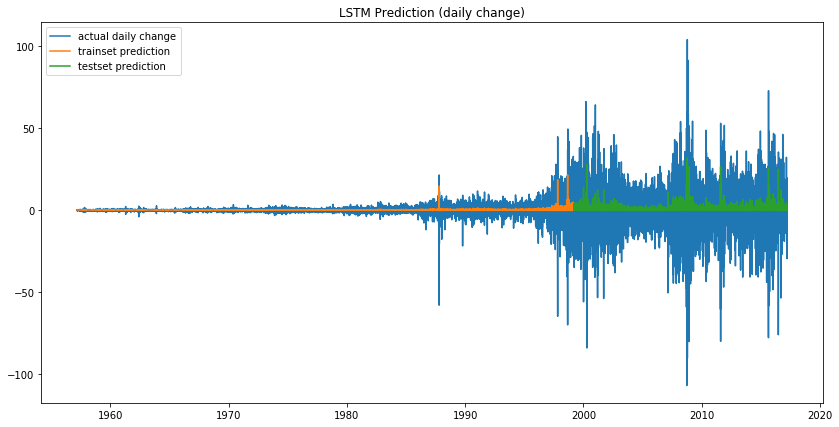

Train Score for LSTM: 3.33 RMSE
Test Score for LSTM: 15.19 RMSE


In [58]:
# Plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(plot_rate)
# plt.plot(plot1['trainPredictPlot'])
# plt.plot(testPredictPlot)
plt.legend(['actual daily change','trainset prediction','testset prediction'])
plt.title('LSTM Prediction (daily change)')
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for LSTM: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for LSTM: %.2f RMSE' % (testScore))

In [59]:
# Inversing data from daily change back to daily level
plot_lvl = pd.concat([sp500['adj_close'],plot_rate],axis=1)

In [60]:
len(plot_lvl)

15119

In [61]:
plot_lvl.dropna(axis=0,thresh=3,inplace=True)
len(plot_lvl)

15117

In [62]:
plot_lvl.tail()

,adj_close,diff,trainPredict,testPredict
date,,,,
2017-03-17,2378.250000,-3.129883,NaN,0.020040
2017-03-20,2373.469971,-4.780029,NaN,-0.034581
2017-03-21,2344.020020,-29.449951,NaN,2.834940
2017-03-22,2348.449951,4.429931,NaN,0.571976
2017-03-23,2345.959961,-2.489990,NaN,0.048094


In [63]:
# train set predictions (inversed from daily change to daily level)
train_close=[]

prev_close = plot_lvl.iloc[0,0] - plot_lvl.iloc[0,1]

for n in plot_lvl['trainPredict']:
    try:
        close = prev_close + n
        train_close.append(close)
        prev_close = close
    except:
        break      

In [64]:
train_close = pd.DataFrame(train_close,columns=['train_close'])
train_close.index = plot_lvl.index
plot_lvl=pd.concat([plot_lvl,train_close],axis=1)
plot_lvl.head()

,adj_close,diff,trainPredict,testPredict,train_close
date,,,,,
1957-03-05,44.220001,0.160000,0.202994,NaN,44.262995
1957-03-06,44.230000,0.009999,0.192621,NaN,44.455616
1957-03-07,44.209999,-0.020001,0.190569,NaN,44.646185
1957-03-08,44.070000,-0.139999,0.182436,NaN,44.828621
1957-03-11,43.779999,-0.290001,0.172438,NaN,45.001059


In [65]:
# test set predictions (inversed from daily change to daily level)
test_close=[]

for n in plot_lvl['testPredict'][:'1999-03-15']:
    test_close.append(np.nan)

prev_close = plot_lvl.loc['1999-03-15','train_close']

for n in plot_lvl['testPredict']['1999-03-17':]:
    close = prev_close + n
    test_close.append(close)
    prev_close = close     

In [66]:
test_close = pd.DataFrame(test_close,columns=['test_close'])
test_close.index = plot_lvl.index
plot_lvl=pd.concat([plot_lvl,test_close],axis=1)

In [67]:
plot_lvl.head()

,adj_close,diff,trainPredict,testPredict,train_close,test_close
date,,,,,,
1957-03-05,44.220001,0.160000,0.202994,NaN,44.262995,NaN
1957-03-06,44.230000,0.009999,0.192621,NaN,44.455616,NaN
1957-03-07,44.209999,-0.020001,0.190569,NaN,44.646185,NaN
1957-03-08,44.070000,-0.139999,0.182436,NaN,44.828621,NaN
1957-03-11,43.779999,-0.290001,0.172438,NaN,45.001059,NaN


In [68]:
plot_lvl.drop(['diff','trainPredict','testPredict'],axis=1,inplace=True)
plot_lvl.head()

,adj_close,train_close,test_close
date,,,
1957-03-05,44.220001,44.262995,NaN
1957-03-06,44.230000,44.455616,NaN
1957-03-07,44.209999,44.646185,NaN
1957-03-08,44.070000,44.828621,NaN
1957-03-11,43.779999,45.001059,NaN


In [69]:
# To verify if size of inversed dataset tallies with original after dropping null values
len(y_test),len(plot_lvl['test_close'].dropna())

(4535, 4535)

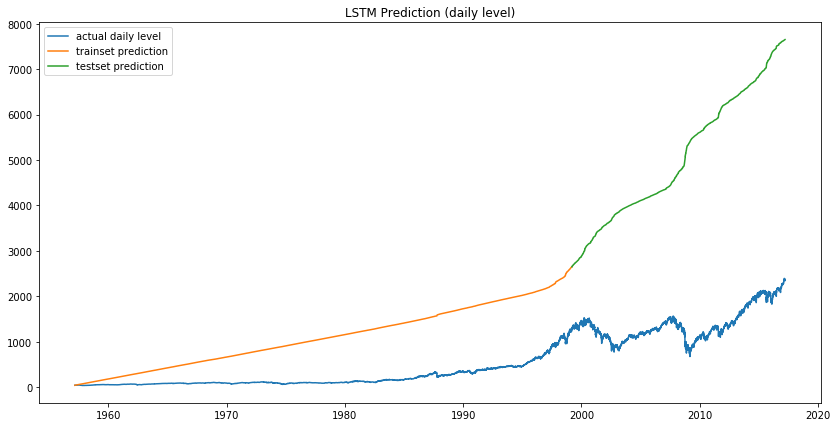

Train Score for LSTM: 1009.18 RMSE
Test Score for LSTM: 3858.76 RMSE


In [70]:
# Define train, test and predictions
y_train=plot_lvl['adj_close'][0:train_size][:-lag]
y_test=plot_lvl['adj_close'][train_size-lag:]
trainPredict=plot_lvl['train_close'].dropna()
testPredict=plot_lvl['test_close'].dropna()

# Plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(plot_lvl)
plt.legend(['actual daily level','trainset prediction','testset prediction'])
plt.title('LSTM Prediction (daily level)')
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for LSTM: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for LSTM: %.2f RMSE' % (testScore))

---
<a name='LSTM_non-sta'></a>
### LSTM on non-stationary data

In [71]:
# Create new dataframe for non-stationary data
data_nonsta=pd.DataFrame(sp500['adj_close'])
data_nonsta.head()

,adj_close
date,
1957-03-05,44.220001
1957-03-06,44.230000
1957-03-07,44.209999
1957-03-08,44.070000
1957-03-11,43.779999


In [72]:
# With full dataset, split train/test into 70:30
train_size = int(len(data_nonsta)*0.7)
test_size = len(data_nonsta) - train_size
train,test=data_nonsta[0:train_size],data_nonsta[train_size:]
print(len(data_nonsta),train_size,test_size)

15119 10583 4536


In [73]:
# Scaling
mms = MinMaxScaler(feature_range=(0,1))
mms = mms.fit(train)
train = mms.transform(train)
test = mms.transform(test)
print(train.shape,test.shape)

(10583, 1) (4536, 1)


In [74]:
lag=1
X_train=np.array(train[:-lag])
y_train=np.array(train[lag:])
X_test=np.array(test[:-lag])
y_test=np.array(test[lag:])

In [75]:
time_steps = 1
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, X_test.shape[1]))

In [76]:
# Create and fit LSTM network
lag=1
np.random.seed(7)
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag))) # 4 neurons
model.add(Dense(1)) # 1 layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
10582/10582 [==============================] - 67s 6ms/step - loss: 0.0028
Epoch 2/20
10582/10582 [==============================] - 59s 6ms/step - loss: 2.3291e-05
Epoch 3/20
10582/10582 [==============================] - 62s 6ms/step - loss: 2.1585e-05
Epoch 4/20
10582/10582 [==============================] - 62s 6ms/step - loss: 2.0037e-05
Epoch 5/20
10582/10582 [==============================] - 63s 6ms/step - loss: 1.8967e-05
Epoch 6/20
10582/10582 [==============================] - 63s 6ms/step - loss: 1.7877e-05
Epoch 7/20
10582/10582 [==============================] - 64s 6ms/step - loss: 1.6688e-05
Epoch 8/20
10582/10582 [==============================] - 67s 6ms/step - loss: 1.5740e-05
Epoch 9/20
10582/10582 [==============================] - 67s 6ms/step - loss: 1.4671e-05
Epoch 10/20
10582/10582 [==============================] - 63s 6ms/step - loss: 1.3843e-05
Epoch 11/20
10582/10582 [==============================] - 71s 7ms/step - loss: 1.3616e-05
Epoch 12/20


In [77]:
# Predict with model
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
print(len(X_train),len(X_test))
print(len(trainPredict),len(testPredict))

10582 4535
10582 4535


In [78]:
# Inverse the transformations
y_train = mms.inverse_transform(y_train)
y_test = mms.inverse_transform(y_test)
testPredict = mms.inverse_transform(testPredict)
trainPredict = mms.inverse_transform(trainPredict)

In [79]:
# adjust non-stationary data (due to lag values)
nonsta_adj = pd.concat([data_nonsta[['adj_close']][0:train_size][:-lag],data_nonsta[['adj_close']][train_size:][:-lag]],axis=0)
len(nonsta_adj)

15117

In [80]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(nonsta_adj) # Return a new empty array with same shape and type as given array
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:train_size-lag, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(nonsta_adj)
testPredictPlot[:, :] = np.nan
testPredictPlot[train_size-lag:, :] = testPredict

# Creating the plots
trainPredictPlot = pd.DataFrame(trainPredictPlot,columns=['trainPredict'])
trainPredictPlot.index=nonsta_adj.index

testPredictPlot = pd.DataFrame(testPredictPlot,columns=['testPredict'])
testPredictPlot.index=nonsta_adj.index

plot_nonsta= pd.concat([nonsta_adj,pd.DataFrame(trainPredictPlot),pd.DataFrame(testPredictPlot)],axis=1)
len(trainPredictPlot),len(testPredictPlot)

(15117, 15117)

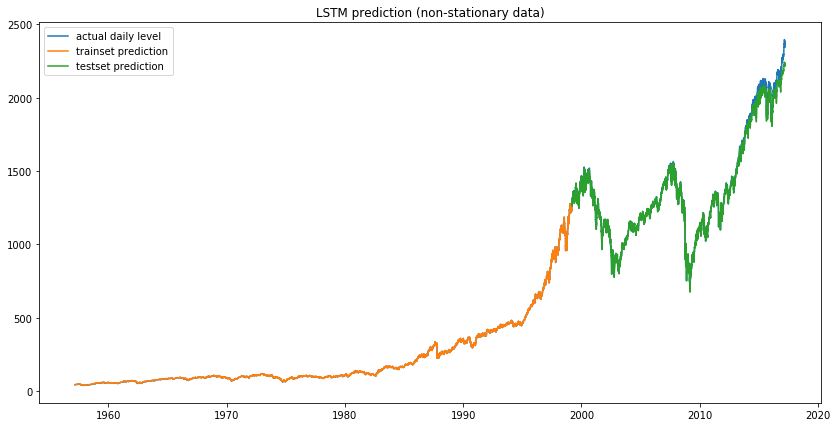

Train Score for LSTM: 3.41 RMSE
Test Score for LSTM: 27.99 RMSE


In [81]:
# Plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(plot_nonsta)
plt.legend(['actual daily level','trainset prediction','testset prediction'])
plt.title('LSTM prediction (non-stationary data)')
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score for LSTM: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score for LSTM: %.2f RMSE' % (testScore))

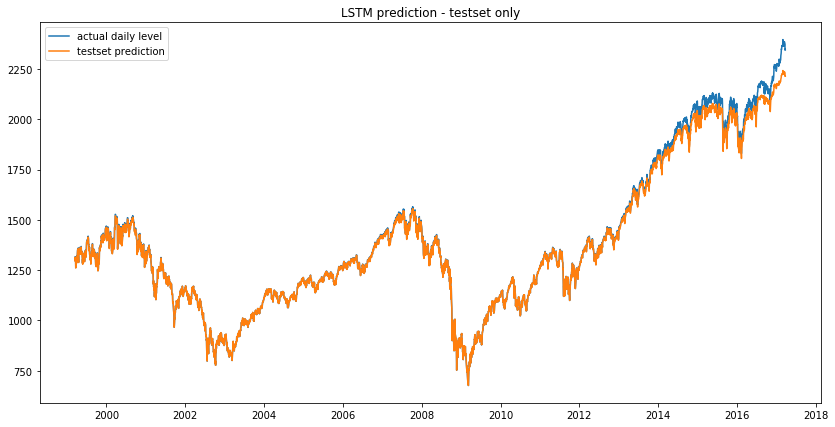

In [82]:
# Plot actual data vs train data for a closer look
plot_test=plot_nonsta.drop('trainPredict',axis=1)
plot_test.dropna(axis=0,inplace=True)
plt.figure(figsize=(14,7))
plt.plot(plot_test)
plt.legend(['actual daily level','testset prediction'])
plt.title('LSTM prediction - testset only')
plt.show()